# Popular Topics in Data Science

The objective for this project is to analyze user activity on [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine the type of content that a data science education company should create.

## Data Science Stack Exchange 

- Identify best topics for new content
    - Questions that remain unanswered

The website is organized by tags, which will help us categorize content.

The data on Stack Exchange is available through a [public database](https://data.stackexchange.com/datascience/query/new), known as Stack Exchange Data Explorer (SEDE).

-SEDE uses  Transact-SQL or T-SQL


https://data.stackexchange.com/datascience/query/new

What topics are popular?
- Which tags have the highest viewer count?

What topics are unique?
- Questions that remain unanswered



```sql
SELECT TOP 10
  p.Id AS [Post Link],
  p.ViewCount,
  p.CreationDate,
  p.Score
FROM 
  Posts p
WHERE 
  p.PostTypeId = 1 -- Limit to questions only
  AND p.AnswerCount = 0 -- Limit to unanswered questions
  AND p.CreationDate >= DATEADD(month, -18, GETDATE()) -- Recent Posts (Last 18 months)
  AND p.Score > 2 -- Limit to posts with score above 2
ORDER BY 
  p.ViewCount DESC;
  ```

Run the following query:

```SQL
SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, 
       AnswerCount, FavoriteCount
  FROM posts
  WHERE PostTypeID = 1 AND YEAR(CreationDate) = 2022
```

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [14]:
questions = pd.read_csv("2022_questions.csv",parse_dates=["CreationDate"])

In [15]:
questions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5343 entries, 0 to 5342
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             5343 non-null   int64         
 1   PostTypeId     5343 non-null   int64         
 2   CreationDate   5343 non-null   datetime64[ns]
 3   Score          5343 non-null   int64         
 4   ViewCount      5343 non-null   int64         
 5   Tags           5343 non-null   object        
 6   AnswerCount    5343 non-null   int64         
 7   FavoriteCount  19 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 334.1+ KB


In [16]:
questions["Tags"].apply(lambda value: type(value)).unique()



array([<class 'str'>], dtype=object)

In [17]:
# replace na with 0 in FavoriteCount
questions.fillna(value={"FavoriteCount": 0}, inplace=True) 

# Convert FavoriteCount datatype to integer
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int) 

questions.dtypes



Id                        int64
PostTypeId                int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int32
dtype: object

In [18]:

questions["Tags"] = questions["Tags"].str.replace("^<|>$", "",regex=True).str.split("><")
questions.sample(3)



,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
2724,112377,1,2022-07-04 12:06:00,0,10,"[mathematics, features]",0,0
2079,111160,1,2022-05-20 08:23:00,0,9,"[dataset, time]",0,0
5322,117398,1,2022-12-29 20:41:00,0,14,"[machine-learning, clustering, k-means]",0,0


In [19]:


tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1



In [20]:


tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)



,Count
python,881
keras,301
tensorflow,316
regression,261
deep-learning,764
word-embeddings,72
deepmind,5
logistic-regression,106
sigmoid,5
machine-learning,1460


In [30]:


most_used = tag_count.sort_values(by="Count",ascending=False).head(15)
most_used



,Count
machine-learning,1460
python,881
deep-learning,764
nlp,446
classification,434
neural-network,430
time-series,368
tensorflow,316
keras,301
scikit-learn,290


<AxesSubplot: >

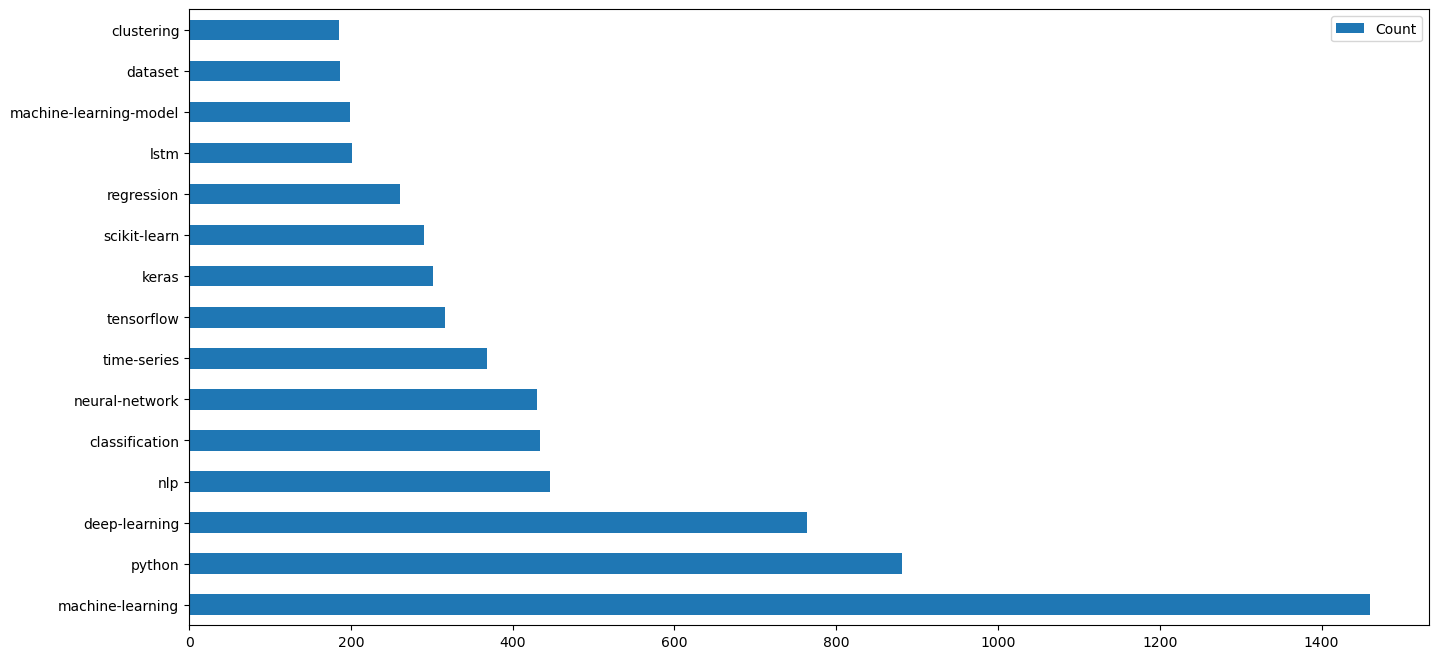

In [31]:


most_used.plot(kind="barh", figsize=(16,8))



<AxesSubplot: >

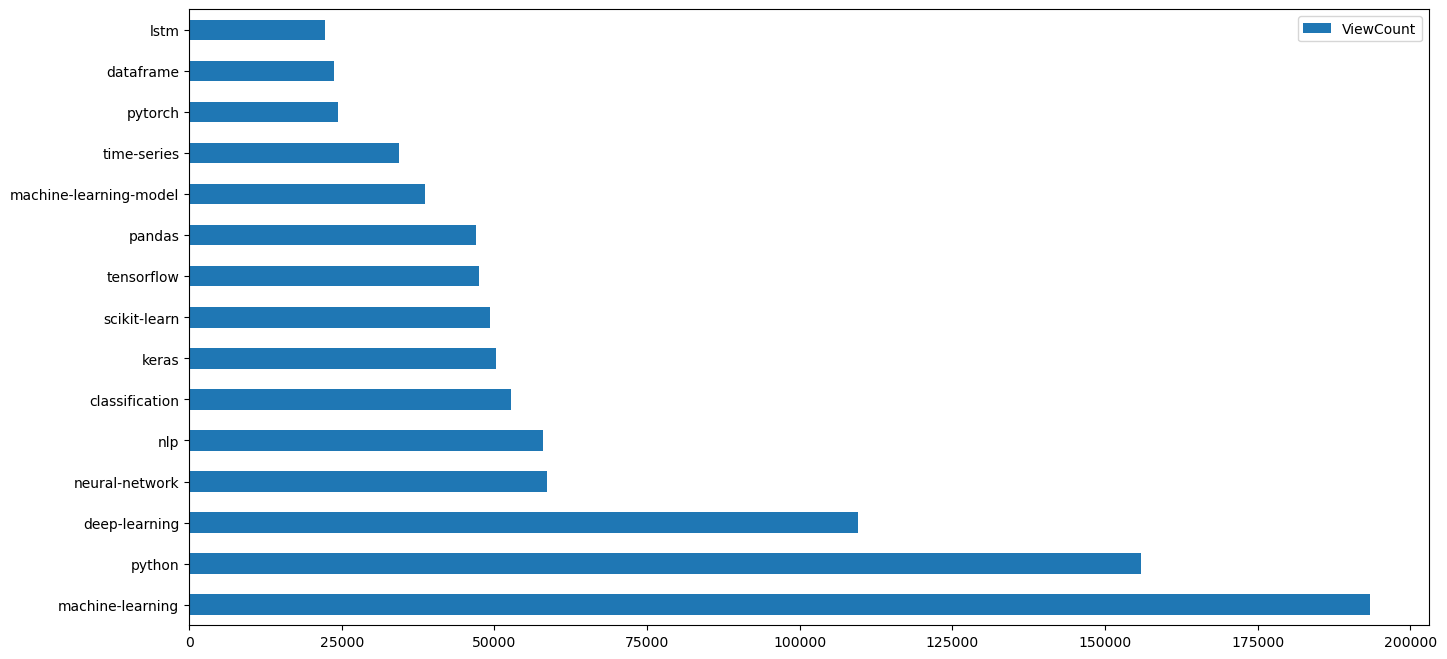

In [34]:


tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount",ascending=False).head(15)

most_viewed.plot(kind="barh", figsize=(16,8))



array([<AxesSubplot: title={'center': 'ViewCount'}>], dtype=object)

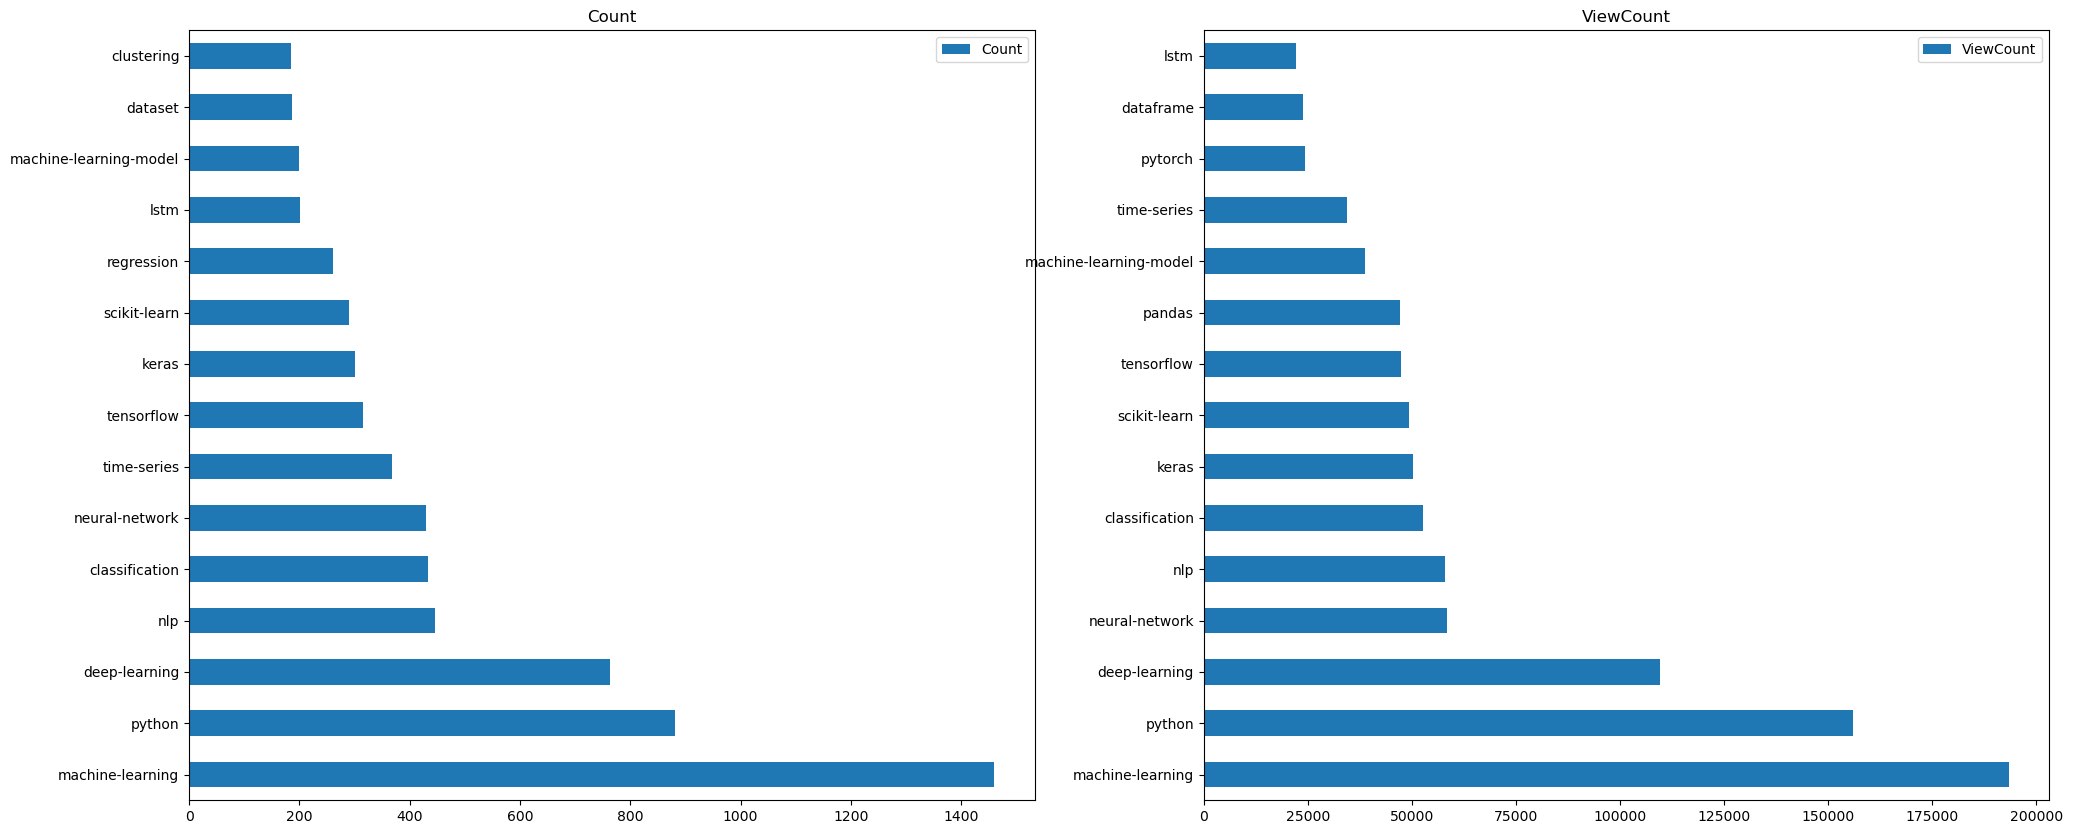

In [35]:


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)



In [36]:


in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

